# MBPLS introduction example

This notebook intends to illustrate how to use Multiblock Partial Least Squares (MBPLS) regression. To make things easier we are going to use a very simple simulated dataset with two X blocks.

MBPLS aims at establishing predictive models using latent variable spaces. In addition to PLS, it provides a measure on how much each X block contributes to the actual prediction of the response Y. The mode is computed such that:
 

## First, we initialize our data simulation by defining the parameters below.
Let's start without noise. Once you have run through this notebook just go ahead and increase the noise. It will give you a feeling for some of the limits of MBPLS.

In [23]:
rand_seed = 25
num_samples = 20
num_vars_x1 = 25
num_vars_x2 = 45
noise = 0      # add noise between 0..10

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ortho_group

## Generate Loadings

In [3]:
np.random.seed(rand_seed)
p1 = np.expand_dims(np.random.randint(0, 10, num_vars_x1), 1)
p2 = np.expand_dims(np.sin(np.linspace(0, 5, num_vars_x2)), 1)

## Plot loadings
To generate some data we define two loading vectors which we will utilize to generate data for $X_1$ and $X_2$, respectively. As you can see below these loading vectors have different characterstic shapes. Further down, we will refer to these lodings as the "ground truth". 

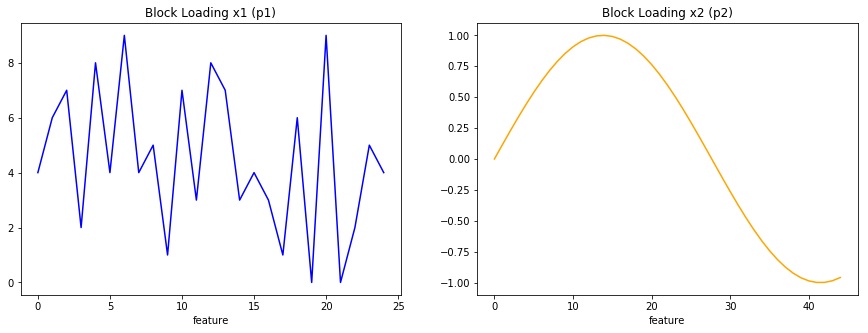

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(p1, color='blue')
ax[0].set_title('Block Loading x1 (p1)')
ax[0].set_xlabel('feature')
ax[1].plot(p2, color='orange')
ax[1].set_title('Block Loading x2 (p2)')
ax[1].set_xlabel('feature');

## Generate orthogonal scores
Here we generate some orthogonal scores. We impose orthogonality to make this analysis clear and simple. Of course, real data would typically deviate from this condition.

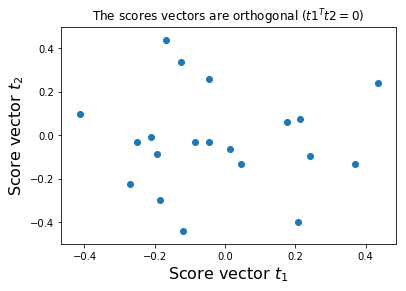

In [8]:
t = ortho_group.rvs(num_samples, random_state=rand_seed)[:, 0:2]
t1 = t[:,0:1]
t2 = t[:,1:2]

plt.figure()
plt.scatter(t1, t2)
plt.xlabel('Score vector $t_1$', size=16)
plt.ylabel('Score vector $t_2$', size=16)
plt.title('The scores vectors are orthogonal ($t1^Tt2 = 0$)');

## Generate data using loadings and scores
Two data blocks are generated. Block $X_1$ is formed as the outer vector product of loading vector $p_1$ and score vector $t_1$. Similarily, the data block $X_2$ is calculated as the outer vector product of loading vector $p_2$ and score vector $t_2$.

$X_1=t_1\cdot p_1^T$

$X_2=t_2\cdotp_2^T$

In [9]:
x1 = np.dot(t1, p1.T)
x2 = np.dot(t2, p2.T)

## Add noise to the data (according to noise parameter)
Here we add some noise to show how this impacts the analysis.

In [10]:
x1 = np.random.normal(x1, 0.05*noise)
x2 = np.random.normal(x2, 0.05*noise)

## Plot data blocks x1 and x2
Let's look at the data blocks $X_1$ and $X_2$. The variance in $X_1$ is related to the first score vector $t_1$ while the variance in $X_2$ is related to the second score vector $t_2$ 

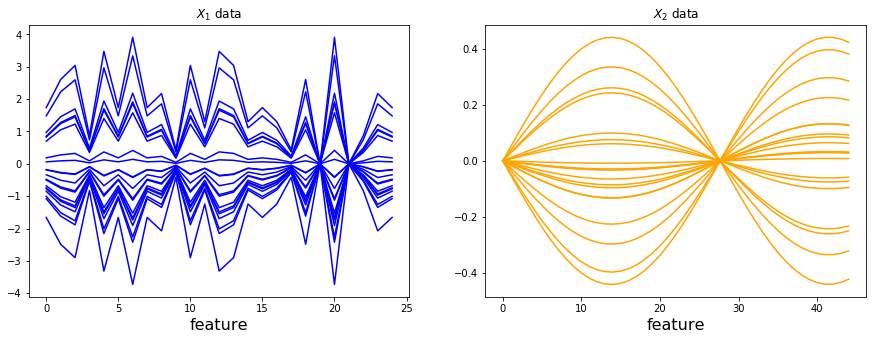

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(x1.T, color='blue') 
ax[0].set_title('$X_1$ data') 
ax[0].set_xlabel('feature', size=16)
ax[1].plot(x2.T, color='orange') 
ax[1].set_title('$X_2$ data') 
ax[1].set_xlabel('feature', size=16);

## Perform MBPLS
We perform MBPLS to simply fit the data. As a result we will obtain block loadings and scores, superscores and block importances. For further information on the algorithms please check out [ref].

With this simple example we aim to find out about the following:

1. How much does each block contribute to the prediction of the score vectors $t_1$ and $t_2$ ($=Y$)? This measure we call block importance (a).
2. What are the feature contributions in each block (block loadings $\hat{p}_1$ and $\hat{p}_2$)?
3. Are the fitted block scores $\hat{t}_1$ and $\hat{t}_2$ describing the ground truth of our chosen block scores $t_1$ and $t_2$?

In [14]:
from mbpls.mbpls import MBPLS
mbpls_model = MBPLS(n_components=2,method='UNIPALS',standardize=False)
mbpls_model.fit(X=[x1, x2], Y=t);

A two component model was fitted to the data. PLS maximizes co-variance between the $t_s$ and $u$ score vectors for each extracted latent variable. When such a projection (latent variable) is found it is used to deflate the explained variance on all data blocks in $X$. After that further latent variables (= components) can be extracted. 
In this example we are fitting the data $X_1$ and $X_2$ simulatenously to $Y$. As $Y$ contains our two known orthogonal score vectors we expect to require two latent variables (LV) to fit the data.

Usually we always recommend to standardize the data blocks. This is important to give the blocks similar weight on the model, i.e. to correct for different feature variances across blocks. However, in this example we do not use standardization because we want to avoid to destroy our imposed orthogonality from above (for illustraton purposes).

Our model is fit such that:

\begin{equation}
\begin{split}
X &= [X_1|X_2|...|X_i] \\
X_i &= T_s P_i^T + E_i \approx T_i P_i^T + E_i \\
Y &= U V^T + E_Y \\
a_{ik} &= ||w_{ik}||_2^2 \\
Y &= X \beta + E \\
\end{split}
\end{equation}

## Plot $\hat{p}_1$ and $\hat{p}_2$ and compare to ground truth loadings $p_1$ and $p_2$

In [15]:
p1_hat = mbpls_model.P_[0][:,0]
p2_hat = mbpls_model.P_[1][:,1]

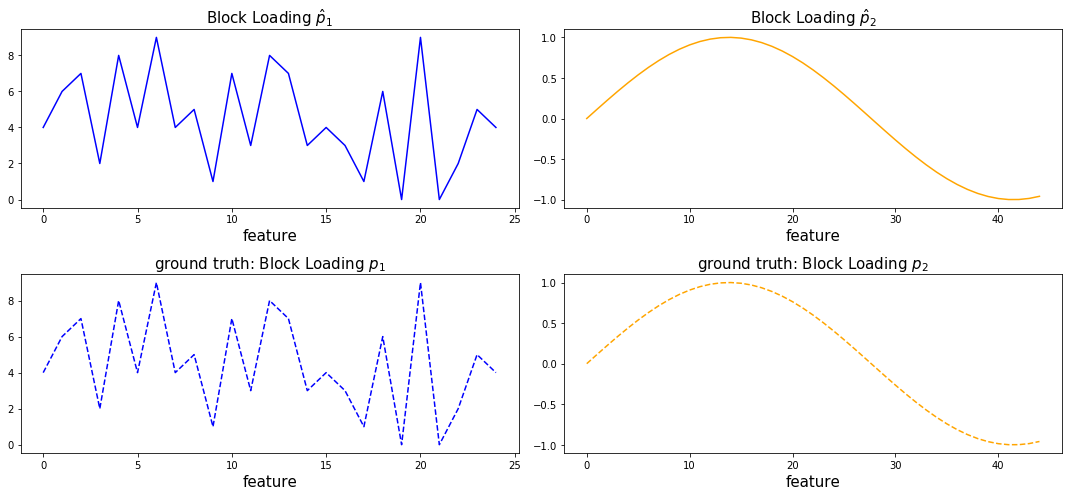

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
ax[0][0].plot(p1_hat, color='blue') 
ax[0][0].set_title('Block Loading $\hat{p}_1$', size=15) 
ax[0][0].set_xlabel('feature', size=15)
ax[0][1].plot(p2_hat, color='orange') 
ax[0][1].set_title('Block Loading $\hat{p}_2$', size=15) 
ax[0][1].set_xlabel('feature', size=15)
ax[1][0].plot(p1,color='blue',ls='--') 
ax[1][0].set_title('ground truth: Block Loading $p_1$', size=15) 
ax[1][0].set_xlabel('feature', size=15)
ax[1][1].plot(p2,color='orange',ls='--') 
ax[1][1].set_title('ground truth: Block Loading $p_2$', size=15)
ax[1][1].set_xlabel('feature', size=15)
plt.tight_layout()

As you can see above the fitted block loadings $\hat{p}_1$ and $\hat{p}_2$ describe our original feature loadings perfectly. Depending on the initialization of the analysis the sign of the loading vectors might switch.

## Block scores $\hat{t}_1$ in LV1 and $\hat{t}_2$ in LV2 are highly correlated to ground truth $t_1$ and $t_2$

In [18]:
t1_hat = mbpls_model.T_[0][:,0]
t2_hat = mbpls_model.T_[1][:,1]
#t1_hat = mbpls_model.Ts_[:,0]
#t2_hat = mbpls_model.Ts_[:,1]

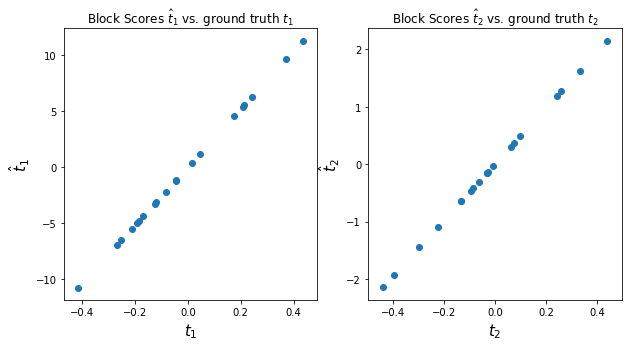

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(t1, t1_hat) 
ax[0].set_title('Block Scores $\hat{t}_1$ vs. ground truth $t_1$')
ax[0].set_xlabel('$t_1$', size=15)
ax[0].set_ylabel('$\hat{t}_1$', size=15)
ax[1].scatter(t2, t2_hat)
ax[1].set_title('Block Scores $\hat{t}_2$ vs. ground truth $t_2$')
ax[1].set_xlabel('$t_2$', size=15)
ax[1].set_ylabel('$\hat{t}_2$', size=15);

## Explained Variance and Block Importance

In [21]:
variances_x = mbpls_model.explained_var_xblocks_
blockimportances = mbpls_model.A_
variance_y = mbpls_model.explained_var_y_

In [22]:
import pandas as pd
variances_x = pd.DataFrame(data=variances_x.T, columns=['expl. var. X1', 'expl. var. X2'], index=['LV1', 'LV2'])
variance_y = pd.DataFrame(data=variance_y, columns=['expl. var. Y'], index=['LV1', 'LV2'])
blockimportances = pd.DataFrame(data=blockimportances.T, columns=['block importance X1', 'block importance X2'], index=['LV1', 'LV2'])
pd.concat((variances_x, blockimportances, variance_y), axis=1).round(3)

,expl. var. X1,expl. var. X2,block importance X1,block importance X2,expl. var. Y
LV1,1.0,0.0,1.0,0.0,0.5
LV2,0.0,1.0,0.0,1.0,0.5
